In [1]:
SCREEN = "20250216_AWALS37_Full_screen_n96"
ANALYSIS = "binary"

In [31]:
from IPython.display import Markdown
Markdown(f"All figures in this notebook were generated from a `{ANALYSIS}` classification analysis of the `{SCREEN}` screen.")

All figures in this notebook were generated from a `binary` classification analysis of the `20250216_AWALS37_Full_screen_n96` screen.

In [3]:
output_dir = Path(params.get("result_dir")) / params.get("screen")
print(output_dir)
with open(output_dir / f"{ANALYSIS}.pkl", "rb") as f:
    results = pickle.load(f)

map_analysis = results["analysis"]

/home/kkumbier/als/analysis_results/20250216_AWALS37_Full_screen_n96


In [4]:
from maps.screens import ImageScreenMultiAntibody
screen = ImageScreenMultiAntibody(params)
plate_dirs = screen.loader._get_plate_dirs()
metadata = screen.loader.load_metadata(plate_dirs[0])
cellline_to_mutation = dict(zip(metadata["CellLines"], metadata["Mutations"]))

In [13]:
import pandas as pd

df_list = []
for genetics, val in map_analysis.fitted.items():
    df = val["predicted"].to_pandas()
    df["ModelGenetics"] = genetics
    df_list.append(df)
    
predictions = pd.concat(df_list)
predictions["Mutations"] = predictions["CellLines"].map(cellline_to_mutation)
predictions = (
    predictions.groupby(["CellLines", "Mutations", "ModelGenetics"])
    .mean()
    .reset_index()
)

For each genetic background `g`, order cell lines within that background by i-MAP scores from a `g` vs WT classifier. For WT and sporadic cell lines, order cell lines by the average i-MAP score across all `g` vs WT classifiers.

In [15]:
from collections import OrderedDict

# Recreate ordered cell lines block
cellline_means = (
    predictions.groupby(["Mutations", "CellLines"])["Class_1"]
    .mean()
    .reset_index()
)

all_groups = cellline_means["Mutations"].unique().tolist()
model_groups = [g for g in all_groups if g not in ["WT", "sporadic"]]

ordered_celllines = []
cellline_to_group = {}

for mutation in all_groups:
    group = cellline_means[cellline_means["Mutations"] == mutation]
    if mutation in model_groups:
        # Order by prediction for that group 
        relevant_cells = predictions[
            (predictions["ModelGenetics"] == mutation) & (predictions["Mutations"] == mutation)
        ]
        
        ordered = (
            relevant_cells.groupby("CellLines")["Class_1"]
            .mean()
            .reset_index()
            .sort_values("Class_1", ascending=False)["CellLines"]
            .tolist()
        )
        
        missing = [c for c in group["CellLines"] if c not in ordered]
        ordered += missing
    else:
        # WT and sporadic: order by mean prediction over all groups
        mean_preds = predictions[
            predictions["CellLines"].isin(group["CellLines"])
        ]
        
        ordered = (
            mean_preds.groupby("CellLines")["Class_1"]
            .mean()
            .reset_index()
            .sort_values("Class_1", ascending=False)["CellLines"]
            .tolist()
        )
        
    ordered_celllines.extend(ordered)
    for cellline in ordered:
        cellline_to_group[cellline] = mutation

# Remove duplicates while preserving order
ordered_celllines = list(OrderedDict.fromkeys(ordered_celllines))

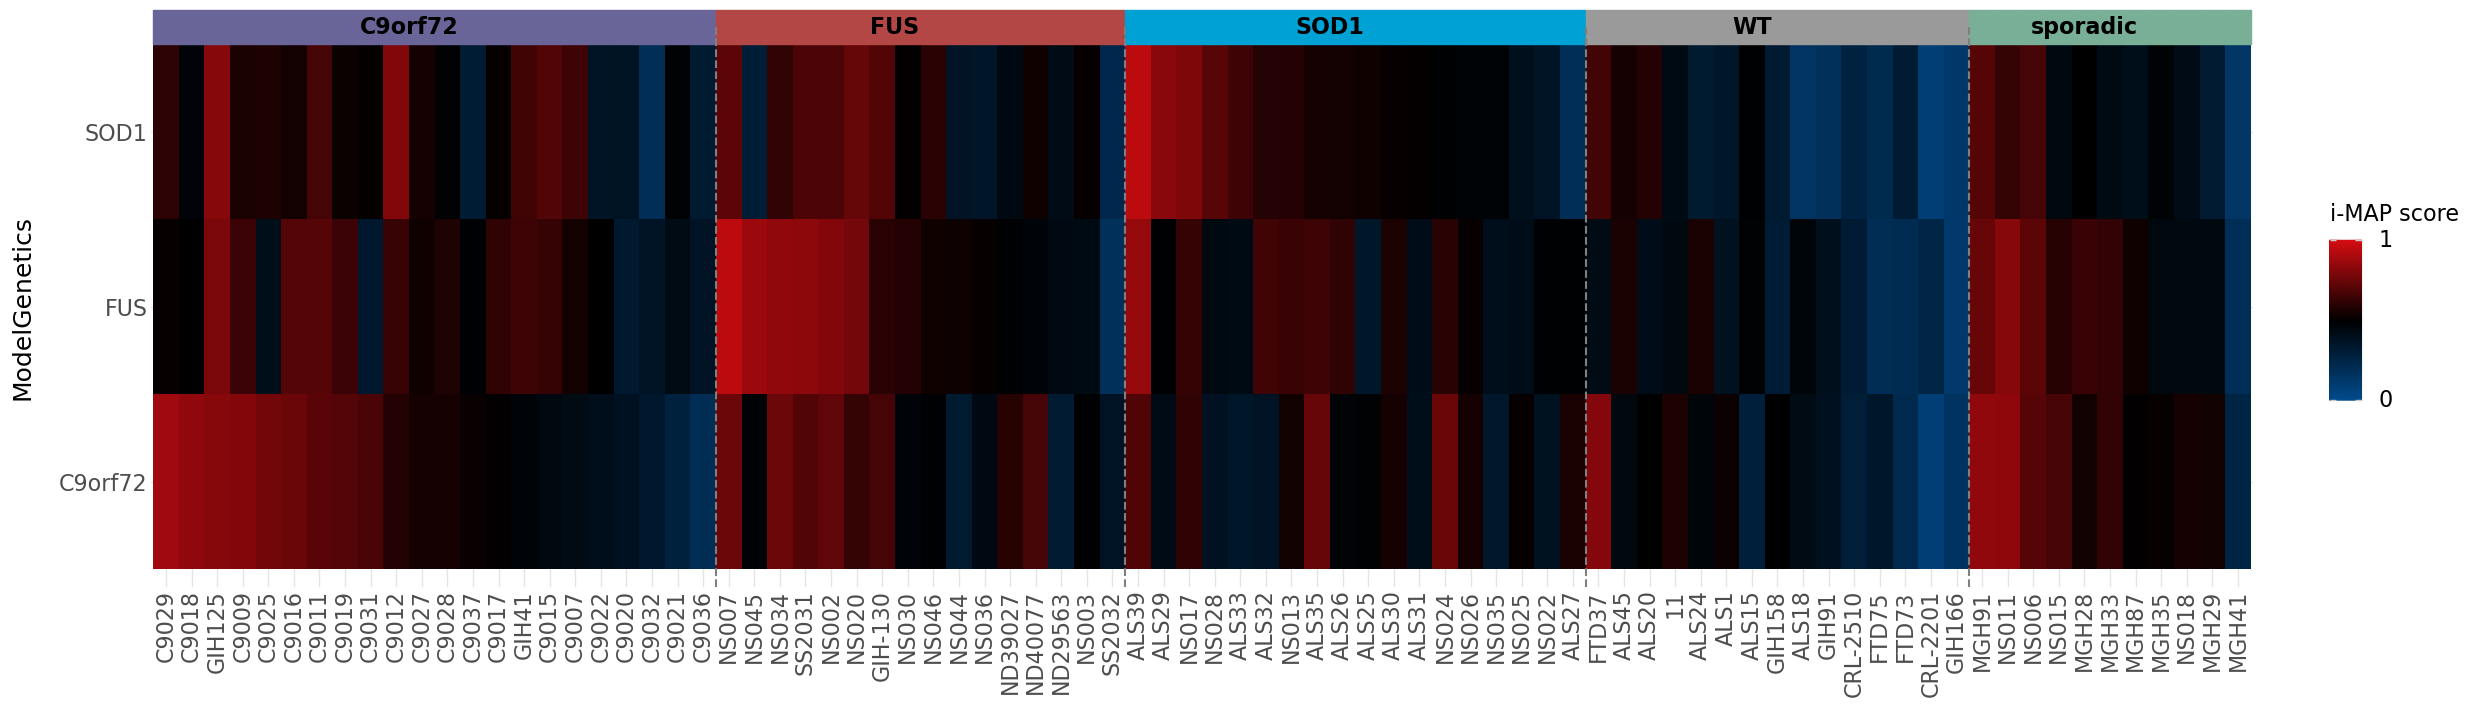

In [16]:
import plotnine as p9
import matplotlib.pyplot as plt
from maps.figures import PALETTE


p9.theme_set(p9.theme_minimal())

# Prepare data for plotnine
plot_df = predictions.copy()
plot_df["Group"] = plot_df["Mutations"]
plot_df["CellLines"] = pd.Categorical(plot_df["CellLines"], categories=ordered_celllines, ordered=True)

# Compute group boundaries for vertical lines and group labels
group_labels = [cellline_to_group.get(cl, "") for cl in ordered_celllines]
unique_groups = []
group_positions = []
for i, group in enumerate(group_labels):
    if i == 0 or group != group_labels[i-1]:
        unique_groups.append(group)
        group_positions.append(i)

group_positions.append(len(group_labels))
group_centers = [
    (group_positions[i] + group_positions[i+1] - 1) / 2 
    for i in range(len(unique_groups))
]

# Cap figure size to avoid PlotnineError
max_width = 25
fig_width = min(len(ordered_celllines) * 0.4 + 4, max_width)
fig_height = min(len(plot_df["ModelGenetics"].unique()) * 0.4 + 6, 12)

# Plot heatmap using plotnine
heatmap_plot = (
    p9.ggplot(
        plot_df, 
        p9.aes(x='CellLines', y='ModelGenetics', fill='Class_1')
    ) +
    p9.geom_tile() +
    p9.scale_fill_gradient2(
        low='#014B8D', 
        mid='#000000', 
        high='#D40C11', 
        midpoint=0.5, 
        limits=(0,1),
        breaks=[0, 1],
        labels=['0', '1']
    ) +
    p9.theme(
        axis_text_x=p9.element_text(angle=90, size=16),
        axis_text_y=p9.element_text(size=16),
        axis_title_y=p9.element_text(size=18),
        axis_title_x=p9.element_blank(),
        legend_text=p9.element_text(size=16),
        legend_title=p9.element_text(size=16),
        plot_title=p9.element_text(size=16),
        figure_size=(fig_width, fig_height),
        legend_position='right'
    ) +
    p9.labs(y='ModelGenetics', fill="i-MAP score") + 
    p9.theme(axis_title_x=p9.element_blank())
)

# Draw plotnine plot and add colorbar above using matplotlib
fig = heatmap_plot.draw()

# Add top colorbar for mutation groups above the axes, twice as thick
ax = fig.axes[0]
col_colors = [PALETTE.get(grp, '#ffffff') for grp in group_labels]
bar_height = 0.2
bar_y = 3.5

for i, color in enumerate(col_colors):
    ax.add_patch(plt.Rectangle((i + 0.5, bar_y), 1, bar_height, color=color, transform=ax.transData, clip_on=False, zorder=2))

# Add group names centered in the color bar
for i, center in enumerate(group_centers):
    ax.text(center, bar_y + bar_height/2, unique_groups[i], ha='center', va='center', fontsize=16, color='black', fontweight='bold', transform=ax.transData, zorder=3)

# Add vertical grey lines to separate groups in heatmap and color bar
for pos in group_positions[1:-1]:
    ax.axvline(pos + 0.5, color='grey', linestyle='--', linewidth=1.5, zorder=2)


fig.subplots_adjust(top=0.92)
display(fig)

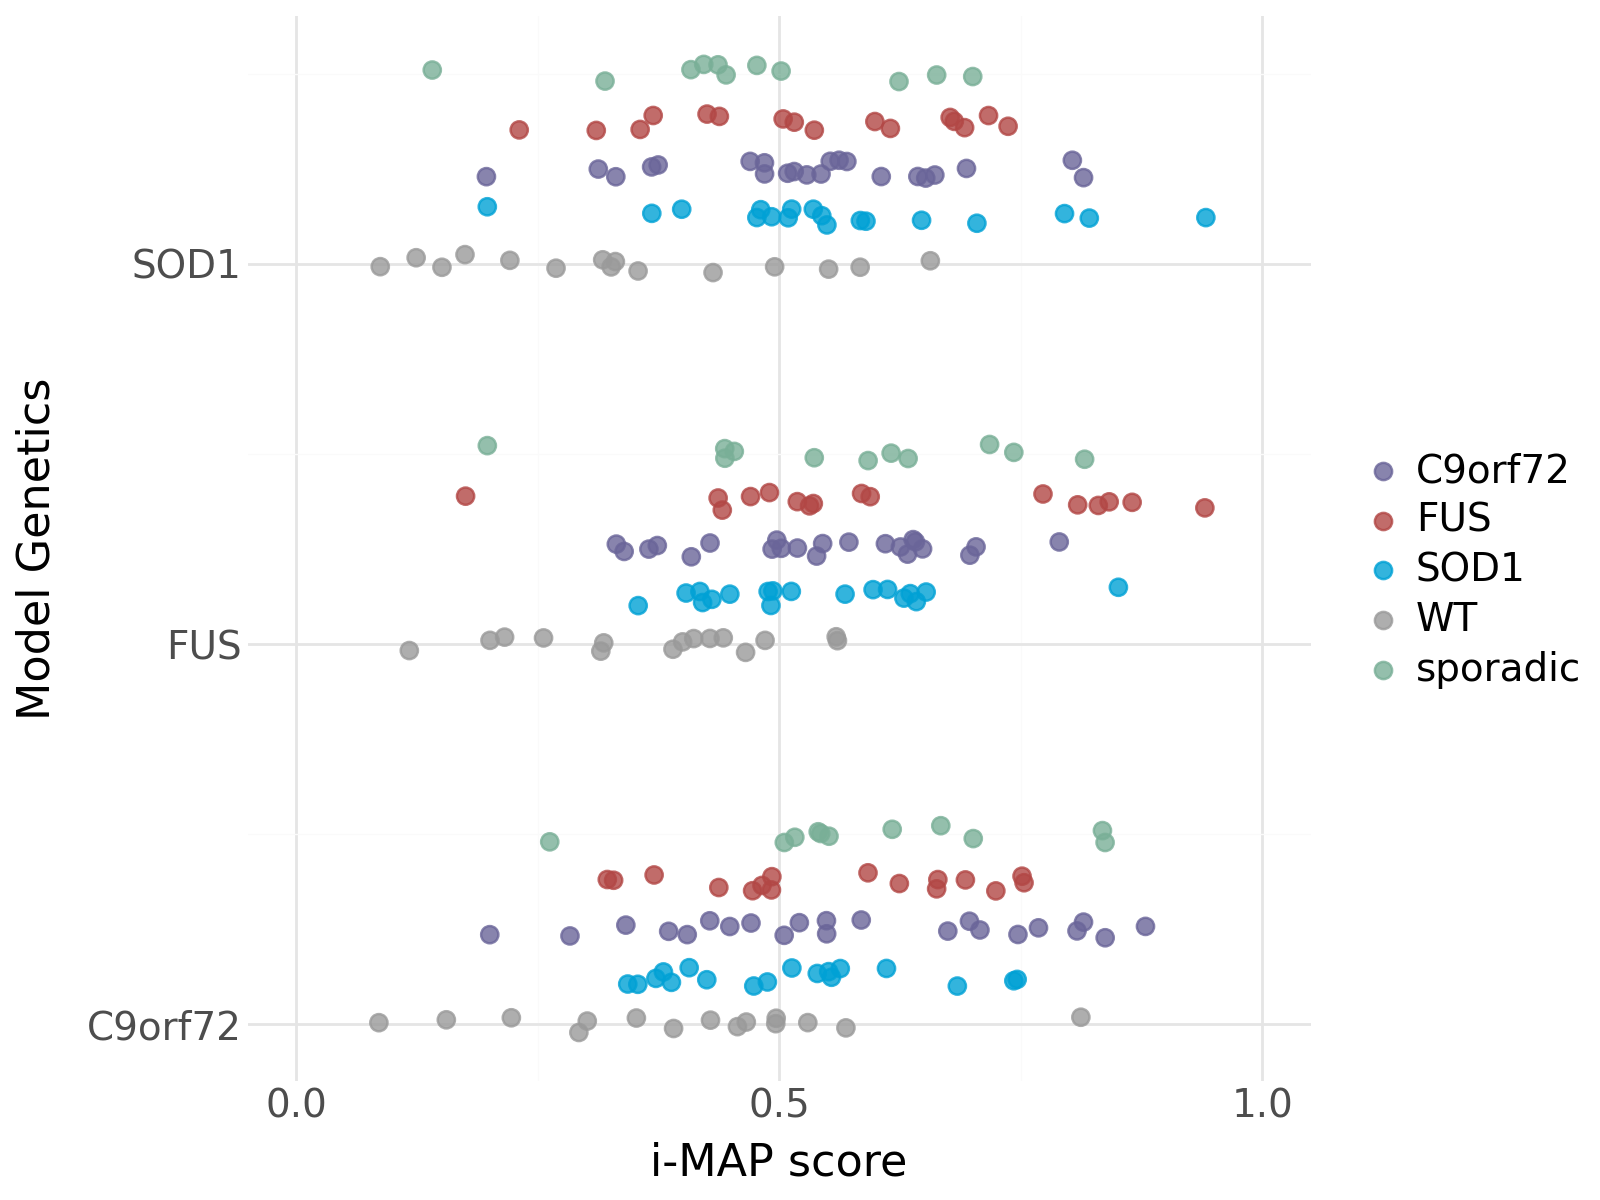

In [28]:
import plotnine as p9
import numpy as np

# Prepare data for scatter plot
scatter_df = predictions.copy()
scatter_df["MutationColor"] = scatter_df["Mutations"].map(PALETTE)
scatter_df["i-MAP score"] = scatter_df["Class_1"]

# Add vertical jitter by Mutation so points for each genetic background are stacked by mutation
mutation_order = {
    mut: i for i, mut in enumerate(scatter_df['Mutations'].unique())
}

scatter_df['mutation_jitter'] = scatter_df['Mutations'].map(mutation_order)
max_mut = scatter_df['mutation_jitter'].max()

scatter_df['mutation_jitter_norm'] = scatter_df['mutation_jitter'] / max_mut 
scatter_df['mutation_jitter_norm'] += np.random.uniform(
    -0.05, 0.05, size=len(scatter_df))

model_order = {
    gen: i for i, gen in enumerate(scatter_df['ModelGenetics'].unique())
}

scatter_df['y_numeric'] = scatter_df['ModelGenetics'].map(model_order)
scatter_df['y_jitter'] = scatter_df['y_numeric'] + scatter_df['mutation_jitter_norm'] * 0.5

# Plot using plotnine
scatter_plot = (
    p9.ggplot(scatter_df, 
        p9.aes(x='i-MAP score', y='y_jitter', color='Mutations')
    ) +
    p9.geom_point(size=3, alpha=0.8) +
    p9.scale_color_manual(values=PALETTE) +
    p9.scale_x_continuous(limits=(0, 1), breaks=[0, 0.5, 1]) +
    p9.scale_y_continuous(breaks=list(model_order.values()), labels=list(model_order.keys())) +
    p9.theme(
        axis_text_x=p9.element_text(size=14),
        axis_text_y=p9.element_text(size=14),
        axis_title_x=p9.element_text(size=16),
        axis_title_y=p9.element_text(size=16),
        legend_text=p9.element_text(size=14),
        legend_title=p9.element_text(size=14),
        plot_title=p9.element_text(size=16),
        figure_size=(8, 6),
        legend_position='right'
    ) +
    p9.labs(
        x='i-MAP score', 
        y='Model Genetics', 
        color='', 
    ) +
    p9.theme(axis_title_y=p9.element_text(margin={'r': 10}))
)

display(scatter_plot)

/tmp/ipykernel_2174597/2705828158.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


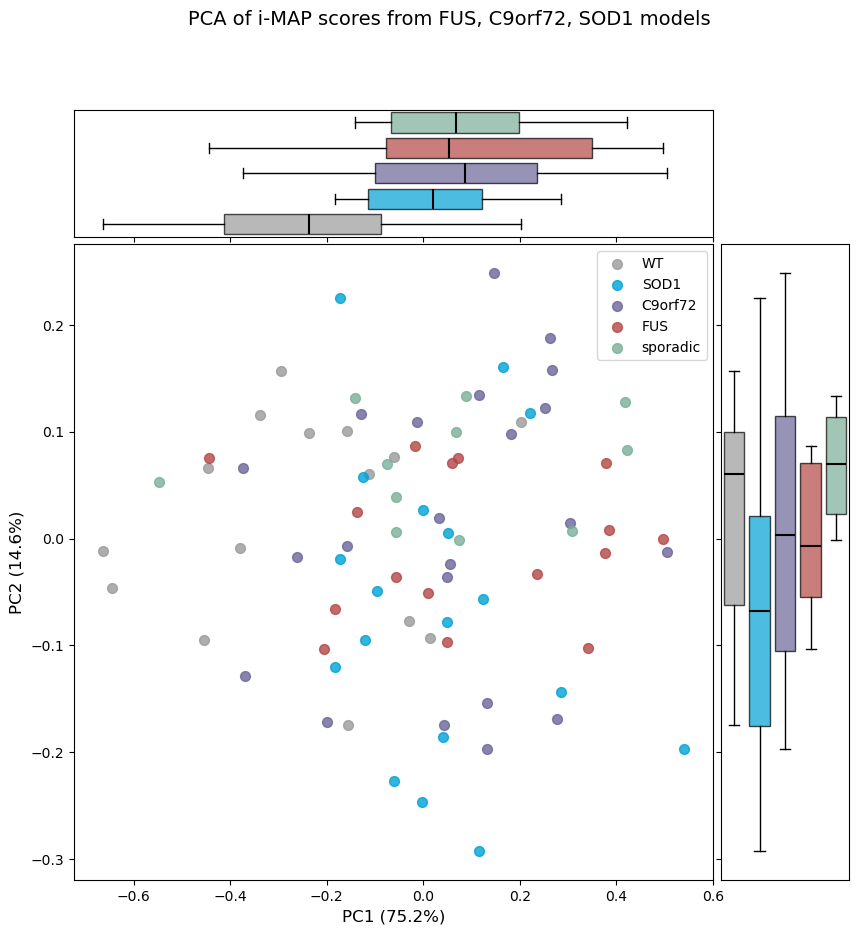

In [27]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from maps.figures import PALETTE

# Create new df with columns for cell line, Mutation, and Class_1 scores from each ModelGenetics
df_pca = predictions.pivot(index=['CellLines', 'Mutations'], columns='ModelGenetics', values='Class_1').reset_index()

# Rename columns for clarity
model_genetics = df_pca.columns[2:]  # First two are CellLines, Mutations
df_pca.columns = ['CellLines', 'Mutations'] + [f'Class_1_{gen}' for gen in model_genetics]

# Perform PCA on the Class_1 scores
pca_cols = [col for col in df_pca.columns if col.startswith('Class_1_')]
pca = PCA(n_components=2, random_state=42)
pca_coords = pca.fit_transform(df_pca[pca_cols])
df_pca['PCA1'] = pca_coords[:, 0]
df_pca['PCA2'] = pca_coords[:, 1]

# Create figure with gridspec for custom layout
fig = plt.figure(figsize=(10, 10))
gs = fig.add_gridspec(2, 2, width_ratios=[5, 1], height_ratios=[1, 5], hspace=0.02, wspace=0.02)

ax_main = fig.add_subplot(gs[1, 0])
ax_top = fig.add_subplot(gs[0, 0], sharex=ax_main)
ax_right = fig.add_subplot(gs[1, 1], sharey=ax_main)

# Main scatterplot
for mutation in df_pca['Mutations'].unique():
    subset = df_pca[df_pca['Mutations'] == mutation]
    ax_main.scatter(subset['PCA1'], subset['PCA2'], 
                   c=[PALETTE[mutation]], label=mutation, alpha=0.8, s=50)

ax_main.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})', fontsize=12)
ax_main.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})', fontsize=12)
ax_main.legend(loc='best', fontsize=10)

# Top boxplot - horizontal boxplots for PCA1 (x-axis) for each mutation
positions = []
for i, mutation in enumerate(df_pca['Mutations'].unique()):
    subset = df_pca[df_pca['Mutations'] == mutation]
    bp = ax_top.boxplot([subset['PCA1']], positions=[i], vert=False, widths=0.8,
                        patch_artist=True, showfliers=False,
                        medianprops=dict(color='black', linewidth=1.5))
    for patch in bp['boxes']:
        patch.set_facecolor(PALETTE[mutation])
        patch.set_alpha(0.7)
    positions.append(i)

ax_top.set_yticks([])
ax_top.tick_params(labelbottom=False, labelleft=False, left=False, right=False)
ax_top.set_ylabel('')

# Right boxplot - vertical boxplots for PCA2 (y-axis) for each mutation  
positions = []
for i, mutation in enumerate(df_pca['Mutations'].unique()):
    subset = df_pca[df_pca['Mutations'] == mutation]
    bp = ax_right.boxplot([subset['PCA2']], positions=[i], vert=True, widths=0.8,
                          patch_artist=True, showfliers=False,
                          medianprops=dict(color='black', linewidth=1.5))
    for patch in bp['boxes']:
        patch.set_facecolor(PALETTE[mutation])
        patch.set_alpha(0.7)
    positions.append(i)

ax_right.set_xticks([])
ax_right.tick_params(labelleft=False, labelbottom=False, bottom=False, top=False)
ax_right.set_xlabel('')

fig.suptitle('PCA of i-MAP scores from FUS, C9orf72, SOD1 models', fontsize=14, y=0.98)
plt.tight_layout()
display(fig)